<a href="https://colab.research.google.com/github/KamoTaueatsoala/AI-mini-project/blob/main/irrigation_semi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

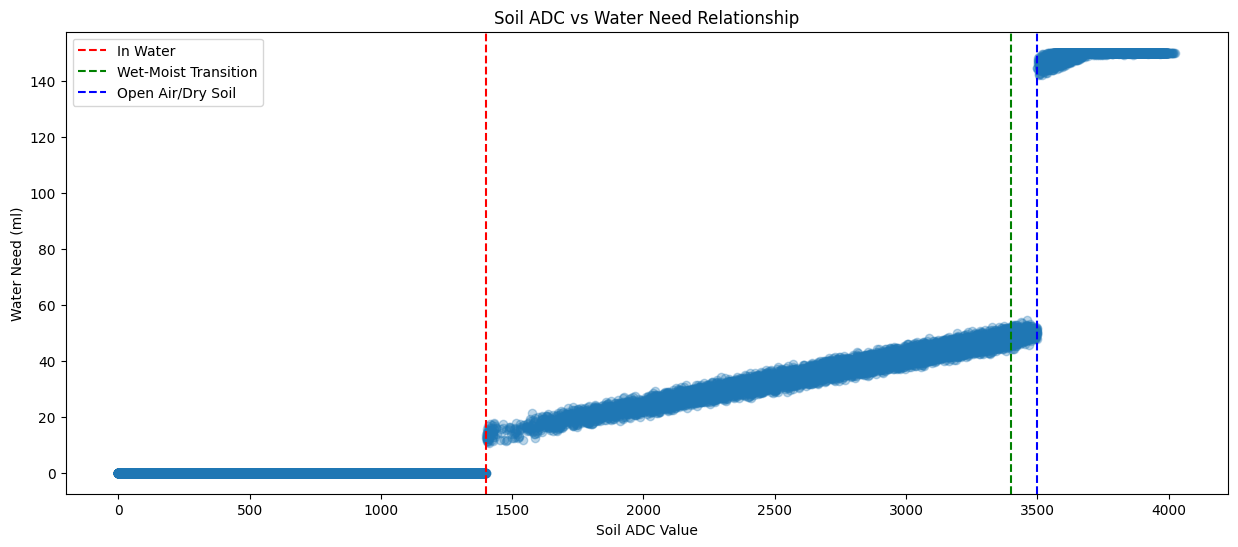

Epoch 1/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 25.1821 - mae: 25.4783 - root_mean_squared_error: 43.2283 - val_loss: 36.1427 - val_mae: 36.4100 - val_root_mean_squared_error: 55.0450 - learning_rate: 0.0050
Epoch 2/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.8556 - mae: 9.0782 - root_mean_squared_error: 16.0515 - val_loss: 20.7554 - val_mae: 21.0028 - val_root_mean_squared_error: 30.2138 - learning_rate: 0.0050
Epoch 3/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.4196 - mae: 6.6307 - root_mean_squared_error: 11.6150 - val_loss: 4.1085 - val_mae: 4.3013 - val_root_mean_squared_error: 6.9873 - learning_rate: 0.0050
Epoch 4/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3686 - mae: 5.5419 - root_mean_squared_error: 10.1865 - val_loss: 5.5119 - val_mae: 5.7196 - val_root_mean_squared_error: 8.7499 - learning_rate: 0.0050
Epoch 5/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.7843 - mae: 5.9690 - root_mean_squared_error: 10.8689 - val_loss:

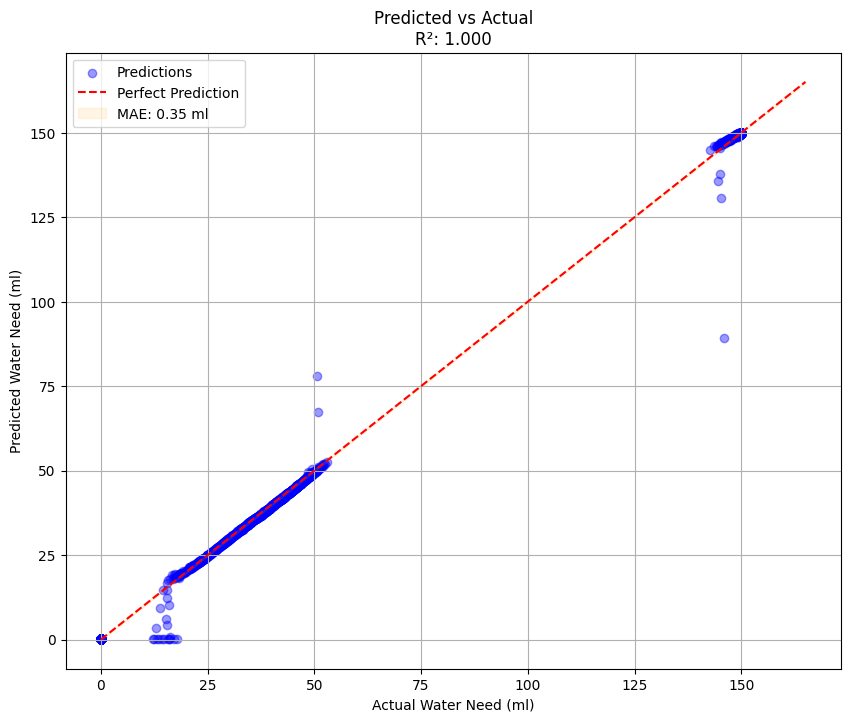

Saved artifact at '/tmp/tmp2ztuyxy_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8), dtype=tf.float32, name='keras_tensor_202')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139136712724112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139136712727184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139136712727568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139136712735824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139136712734480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139136712729296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139136712736208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139136712726416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139136712734864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139136712723920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139136712736016: Ten

0

In [14]:
# -*- coding: utf-8 -*-
"""irrigation.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/github/KamoTaueatsoala/ML-Projects/blob/main/irrigation.ipynb
"""

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Constants
MAX_SENSOR_VALUE = 4095
MIN_TEMP = 10.0
MAX_TEMP = 45.0
MAX_HUMIDITY = 100.0

# Soil moisture thresholds
IN_WATER_THRESHOLD = 1400    # Sensor in water
WET_MOIST_THRESHOLD = 3400   # Wet to moist soil
OPEN_AIR_MIN = 3500          # Open air/dry soil
OPEN_AIR_MAX = 3699          # Open air maximum

def generate_water(soil, temp, humidity, hour):
    """Adjusted water calculation for realistic volumes suitable for parsley in typical gardens (e.g., 50-150 ml)"""
    if soil <= IN_WATER_THRESHOLD:
        return 0.0

    # Normalized soil moisture (0=wet, 1=dry)
    soil_norm = (soil - IN_WATER_THRESHOLD) / (OPEN_AIR_MAX - IN_WATER_THRESHOLD)

    # Base water needs - scaled for parsley, capped at realistic levels
    if soil >= OPEN_AIR_MIN:
        base_water = 50.0 + soil_norm * 100.0  # 50-150 ml for dry soil
    else:
        base_water = 10.0 + soil_norm * 40.0   # 10-50 ml for moist soil
    base_water = min(base_water, 150.0)  # Cap maximum at 150 ml

    # Environmental adjustments, moderated for better balance
    temp_adj = 5.0 * ((temp - MIN_TEMP) / (MAX_TEMP - MIN_TEMP))  # Reduced sensitivity
    hum_adj = 3.0 * (1 - (humidity / MAX_HUMIDITY))  # Reduced humidity impact

    # Time of day effect, moderated
    hour_adj = 1.0 * np.cos((hour - 14) * np.pi / 12)

    # Combine factors - soil dryness has strongest influence, but capped
    water_ml = base_water + temp_adj + hum_adj + hour_adj
    return max(0, min(water_ml, 150.0))  # Ensure output stays within 0-150 ml

def generate_features(soil, temp, humidity, hour):
    """Generate features with proper soil-water relationship"""
    temp_norm = (temp - MIN_TEMP) / (MAX_TEMP - MIN_TEMP)
    hum_norm = humidity / MAX_HUMIDITY
    soil_norm = (soil - IN_WATER_THRESHOLD) / (OPEN_AIR_MAX - IN_WATER_THRESHOLD)  # 0-1 scale

    return np.column_stack((
        soil_norm,  # Direct soil dryness measure
        temp_norm,
        hum_norm,
        np.sin(hour * np.pi / 12),
        np.cos(hour * np.pi / 12),
        soil_norm * temp_norm,  # Interaction terms
        soil_norm * hum_norm,
        temp_norm * hum_norm
    ))

def load_data():
    """Generate training data with increased wet soil representation"""
    np.random.seed(42)
    num_samples = 30000

    # Generate soil values with balanced distribution
    soil = np.concatenate([
        np.random.randint(0, IN_WATER_THRESHOLD, num_samples//3),  # 33% wet soil
        np.random.triangular(IN_WATER_THRESHOLD, WET_MOIST_THRESHOLD, OPEN_AIR_MIN, num_samples//3),
        np.random.triangular(OPEN_AIR_MIN, OPEN_AIR_MAX, OPEN_AIR_MAX+300, num_samples//3)
    ])[:num_samples]  # Ensure correct size

    # Environmental conditions
    temp = np.random.normal(25, 10, num_samples)
    temp = np.clip(temp, MIN_TEMP, MAX_TEMP)
    humidity = np.random.normal(50, 25, num_samples)
    humidity = np.clip(humidity, 10, MAX_HUMIDITY)
    hour = np.random.randint(0, 24, num_samples)

    # Add sensor noise
    soil += np.random.normal(0, 20, size=soil.shape).astype(int)  # Reduced noise
    soil = np.clip(soil, 0, MAX_SENSOR_VALUE)

    water = np.array([generate_water(s,t,h,hr) for s,t,h,hr in zip(soil, temp, humidity, hour)])

    # Visualization
    plt.figure(figsize=(15,6))
    plt.scatter(soil, water, alpha=0.3)
    plt.axvline(IN_WATER_THRESHOLD, color='r', linestyle='--', label='In Water')
    plt.axvline(WET_MOIST_THRESHOLD, color='g', linestyle='--', label='Wet-Moist Transition')
    plt.axvline(OPEN_AIR_MIN, color='b', linestyle='--', label='Open Air/Dry Soil')
    plt.title("Soil ADC vs Water Need Relationship")
    plt.xlabel("Soil ADC Value")
    plt.ylabel("Water Need (ml)")
    plt.legend()
    plt.show()

    X = generate_features(soil, temp, humidity, hour)
    y = water.reshape(-1, 1)
    return train_test_split(X, y, test_size=0.15, random_state=42)

# Load data
X_train, X_test, y_train, y_test = load_data()

# Enhanced model with fixed learning rate
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(8,)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.005),
        loss=tf.keras.losses.Huber(delta=1.0),
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

    return model

model = create_model()

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-5,
    verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1)

# Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Metrics:")
print(f"- MAE: {mae:.4f} ml")
print(f"- R²: {r2:.4f}")

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.4, c='blue', label='Predictions')
max_water = max(np.max(y_test), np.max(y_pred)) * 1.1
plt.plot([0, max_water], [0, max_water], 'r--', label='Perfect Prediction')
plt.fill_between([0, max_water], [0-mae, max_water-mae], [0+mae, max_water+mae],
                color='orange', alpha=0.1, label=f'MAE: {mae:.2f} ml')
plt.xlabel('Actual Water Need (ml)')
plt.ylabel('Predicted Water Need (ml)')
plt.title(f'Predicted vs Actual\nR²: {r2:.3f}')
plt.legend()
plt.grid(True)
plt.show()

# TFLite conversion (FLOAT32 version)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = []  # Disable quantization
converter.target_spec.supported_types = [tf.float32]  # Force float32
tflite_model = converter.convert()

with open('water_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("\nModel size:", len(tflite_model), "bytes")

# Generate C header
from subprocess import call
call("echo 'const unsigned char model[] = {' > model.h", shell=True)
call("cat water_model.tflite | xxd -i >> model.h", shell=True)
call("echo '};' >> model.h", shell=True)
call("echo 'const unsigned int model_len = sizeof(model);' >> model.h", shell=True)